In [18]:
# import the necessary libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import spotipy.util as util
import base64
import requests
import string
import random
from statistics import mean
from collections import Counter

In [19]:
# load the medium or small datasets. Furthermore,
spis = pd.read_csv('generatedDatasets/spotifyDatasetMed.csv', low_memory=False)
#spis = pd.read_csv('generatedDatasets/spotifyDatasetSmall.csv', low_memory=False)
spis = spis.dropna()
spis = spis.drop_duplicates()

In [20]:
# load the predicted values from cnn
# define an empty list
cnnPreds = []
# open predictions file and read the content in a list
#with open('generatedDatasets/predictedGenresSmall.txt', 'r') as filehandle:
with open('generatedDatasets/predictedGenresMed.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        cnnPreds.append(currentPlace)
spis['predicted'] = cnnPreds

In [21]:
# create a "playlist" dataframe as the one that will be used turing testing
dict = {'trackname': spis['trackname'], "artist":spis['artist'], "genres": spis['genres'], "main_genre": spis['main_genre'].str.replace('-',''), "predicted": spis['predicted'].str.replace('-','')}
#dict = {'trackname': spis['trackname'], "artist":spis['artist'], "genres": spis['genres'], "main_genre": spis['main_genre']}
playlist = pd.DataFrame(dict)
playlist = playlist.dropna()
playlist = playlist.drop_duplicates()
print(len(playlist))

3421


In [22]:
print(Counter(playlist['main_genre']))

Counter({'blues': 200, 'alternative': 200, 'electronic': 198, 'jazz': 197, 'indie': 197, 'r&b': 194, 'hiphop': 193, 'punk': 193, 'rap': 192, 'metal': 192, 'soul': 192, 'classical': 191, 'rock': 187, 'country': 184, 'pop': 171, 'latin': 157, 'folk': 151, 'dance': 134, 'reggae': 98})


In [23]:
# load the generated dataset, with enriched data from similar artists' function of spotify
mainer = pd.read_csv('generatedDatasets/forCosineLinearMed.csv', low_memory=False)
mainer = mainer.dropna()
print(len(mainer))
print(mainer.head())

2412
          genre                                            artists
1           rap  postmalone kendricklamar kidcudi aaprocky aapr...
2      softrock  eltonjohn bobseger johndenver stevemillerband ...
3   post-grunge  nickelback shinedown breakingbenjamin soulasyl...
4           pop  justintimberlake fareastmovement stillwoozy mi...
5  post-teenpop  fareastmovement cleanbandit kerihilson onedire...


#### CountVectorizer and Cosine Similarity

In [24]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(mainer['artists'])
count_matrix.shape

(2412, 13370)

In [25]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

csimilarity = cosine_similarity(count_matrix, count_matrix)

#### TfidfVectorizer and Linear Kernel

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(mainer['artists'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(2412, 13370)

In [27]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
lkernel = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
kernelscores = list(enumerate(lkernel[6]))
similarityscores = list(enumerate(csimilarity[6]))

#### Start the Reccomendation Process

In [29]:
# Reset index of your main DataFrame and construct reverse mapping as before
mainer = mainer.reset_index()
indices = pd.Series(mainer.index, index=mainer['genre'])

In [30]:
# Function that takes in a genre, the cosine similarity & linear kernel scores and returns the genres similiar to the one given
def get_recommendations(title, cs, ker):
    # Get the index of the genre that matches the given input
    idx = indices[title]

    # Get the pairwsie similarity scores of all genres, given the initial genre
    similarityscores = list(enumerate(cs[idx]))
    
    kernelscores = list(enumerate(ker[idx]))
    
    meaned = [(kers[0], (kers[1] + sims[1])/2) for kers, sims in zip(kernelscores, similarityscores)]

    # Sort the genres based on the similarity scores
    meaned = sorted(meaned, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar genres
    #sim_scores = sim_scores[0:26]
    
    # get the genres with positive similarity
    meaned = [t for t in meaned if t[1] > 0.005] # me > 0.01 argei polu na kanei suglush se mikro dataset ////
    # EINAI KALO NA TO PEIRAZEIS OMWS SE MEGALUTERA DATASETS GIATI ALLIWS MAZEUEI PARA POLLA KAI O RECOMMENDER SUGLINEI
    # KATEFTHEIAN, GINETAI TROMERA GREEDY KAI XANETAI H POIOTHTA

    # Get the genre indices
    genre_indices = [i[0] for i in meaned]
    
    todf = {"movie": mainer['genre'].iloc[genre_indices]}
    adf = pd.DataFrame(todf)
    setted = set(mainer['genre'].iloc[genre_indices])

    # Return the genres with positive similarity to the given one
    return setted

#### Functions to test the performance of the recommender

In [31]:
def performanceTesting(chosengenre):
    global mainer
    global csimilarity
    global lkernel
    global playlist
    plst = playlist
    totall = len(plst['trackname'])
    isokay = 0
    consplays = 0
    fiveconsecs = 0
    fccc = 0
    plays = 0
    skips = 1
    unlock = 0
    reason = ""
    cgenres = []
    try:
        cgenres = get_recommendations(chosengenre, csimilarity, lkernel)
    except:
        # when initial genre is not in the enriched list. Rare, but happens
        sim = [s for s in playlist['genres'] if chosengenre in s]
        grs = sim[0].split(' ')
        similargenre = grs[1]
        cgenres = get_recommendations(similargenre, csimilarity, lkernel)

    while (isokay == 0):
        ml = 0
        #smart function for when there is no good progress
        if(skips == 18 and plays <= 6):
            if (unlock == 0):
                print("UNLOCK TRIGGERED")
                unlock = 1
                sim = [s for s in playlist['genres'] if chosengenre in s]
                grs = sim[0].split(' ')
                similargenre = grs[1]
                cgenres = get_recommendations(similargenre, csimilarity, lkernel)
        # get a random track from the playlist and check if it 'agrees' with the given genre       
        ras = list(plst['trackname'])
        randtrack = random.choice(ras)
        ss = plst.loc[plst['trackname'] == randtrack, 'genres'].iloc[0].split(' ')
        mg = plst.loc[plst['trackname'] == randtrack, 'main_genre'].iloc[0]
        predicted = plst.loc[plst['trackname'] == randtrack, 'predicted'].iloc[0]
        ss = list(filter(None, ss))
        keepit = 1
        for cg in cgenres:
            if cg in ss:
                keepit = 0
        
        if mg in cgenres:
            keepit = 0

        # if the random track is of the same genre as the given one, move on. If not, then get recommendations for similar genres to that and remove their songs           
        if keepit == 0:
            fiveconsecs = fiveconsecs + 1
            consplays = consplays + 1
            plays = plays + 1
            if fiveconsecs == 5:
                fccc = fccc + 1
                fiveconsecs = 1
            # conditions that terminate the process
            if consplays == 10:
                reason = "Ten consecutive plays occurred."
                isokay = 1
            if plays == 17:
                reason = "Average listening session duration ended (1 hour)."
                isokay = 1
        else:
            for s in ss:
                # check if the machine learning prediction is correct (meaning if the predicted genre is part of one of the song artist's genres)
                # split for the scenario that the 12 merged label dataset is used
                pre = predicted.split(" / ")
                for pr in pre:
                    if pr == "hip-hop":
                        pr = "hiphop"
                    if pr in s:
                        print("Machine Learning Prediction Correct!")
                        ml = 1
            # if the prediction is correct, then boost the removal process
            if ml == 1:
                siml = [s for s in playlist['genres'] if 'alternative' in s]
                for si in siml:
                    grss = si.split(' ')
                    for gr in grss:
                        if predicted in gr:
                            plst = plst[~plst.genres.str.contains(gr)]
            # remove the skipped songs genres (which means, their songs as well), as well as the... genres similar to those genres (and their songs)
            for s in ss:
                try:
                    sets = get_recommendations(s, csimilarity, lkernel)
                    for st in sets:
                        gen = " " + st + " "
                        plst = plst[~plst.genres.str.contains(gen)]
                except:
                    continue
            try:
                sets = get_recommendations(mg, csimilarity, lkernel)
                for st in sets:
                    gen = " " + st + " "
                    plst = plst[~plst.genres.str.contains(gen)]
            except:
                continue
                
            fiveconsecs = 0
            consplays = 0
            skips = skips + 1
    # print the results
    print("Performance testing ended! Main Genre preference:", chosengenre, "with",len(cgenres),"similar genres. Here are the stats: ->")
    print("Reason for termination of the performance testing session:", reason)
    print("Total skips:", (skips-1), ". Total plays:", plays,". Five consecutive plays for:", fccc, "times.")
    print("Play / Skip Ratio per Hour:", round((plays / skips), 2), "PSh")
    print("Songs to listen to:", len(plst['trackname']), "from", totall, "total tracks." )
    return plays, skips, round((plays / skips), 2), fccc, unlock

In [32]:
# datasets where the performance data will be stored
rockdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
classicaldf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
dancedf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
electrodf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
folkdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
hiphopdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
rapdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
jazzdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
bluesdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
metaldf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
popdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
punkdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
souldf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
reggaedf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
countrydf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
indiedf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
altdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
latindf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])
rbdf = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays', 'unlock'])

In [33]:
def totalPerformance(genre):
    dff = pd.DataFrame(columns = ['plays', 'skips', 'p/s_ratio', 'five_cons_plays'])
    for f in range (1,11):
        print("Round", f, ":")
        plays, skips, psh, fc, unlock = performanceTesting(genre)
        dff = dff.append({'plays': plays, 'skips': skips, 'p/s_ratio': psh, 'five_cons_plays': fc, 'unlock': unlock}, ignore_index=True)
    return dff

#### Generate the Performance Data for Each Genre

In [34]:
rockdf = totalPerformance("rock")
print("")
print("---------------------")
print("")
classicaldf = totalPerformance("classical")
print("")
print("---------------------")
print("")
dancedf = totalPerformance("dance")
print("")
print("---------------------")
print("")
electrodf = totalPerformance("electronic")
print("")
print("---------------------")
print("")
folkdf = totalPerformance("folk")
print("")
print("---------------------")
print("")
hiphopdf = totalPerformance("hiphop")
print("")
print("---------------------")
print("")
rapdf = totalPerformance("rap")
print("")
print("---------------------")
print("")
jazzdf = totalPerformance("jazz")
print("")
print("---------------------")
print("")
bluesdf = totalPerformance("blues")
print("")
print("---------------------")
print("")
metaldf = totalPerformance("metal")
print("")
print("---------------------")
print("")
popdf = totalPerformance("pop")
print("")
print("---------------------")
print("")
punkdf = totalPerformance("punk")
print("")
print("---------------------")
print("")
souldf = totalPerformance("soul")
print("")
print("---------------------")
print("")
reggaedf = totalPerformance("reggae")
print("")
print("---------------------")
print("")
countrydf = totalPerformance("country")
print("")
print("---------------------")
print("")
indiedf = totalPerformance("indie")
print("")
print("---------------------")
print("")
altdf = totalPerformance("alternative")
print("")
print("---------------------")
print("")
latindf = totalPerformance("latin")
print("")
print("---------------------")
print("")
rbdf = totalPerformance("r&b")
print("")
print("---------------------")
print("")

Round 1 :
Performance testing ended! Main Genre preference: rock with 320 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 6 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 2.43 PSh
Songs to listen to: 1312 from 3421 total tracks.
Round 2 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: rock with 320 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 5 . Total plays: 17 . Five consecutive plays for: 2 times.
Play / Skip Ratio per Hour: 2.83 PSh
Songs to listen to: 1675 from 3421 total tracks.
Round 3 :
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: rock with 320 similar genres. Here are the stats: ->
Reason for ter

Performance testing ended! Main Genre preference: classical with 46 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 28 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 0.59 PSh
Songs to listen to: 801 from 3421 total tracks.

---------------------

Round 1 :
Performance testing ended! Main Genre preference: dance with 107 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 15 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 1.06 PSh
Songs to listen to: 682 from 3421 total tracks.
Round 2 :
Performance testing ended! Main Genre preference: dance with 107 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 ho

UNLOCK TRIGGERED
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: electronic with 181 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 380 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.04 PSh
Songs to listen to: 501 from 3421 total tracks.
Round 10 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: electronic with 181 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 264 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.06 PSh
Songs to listen to: 511 from 3421 total tracks.

-------------

Performance testing ended! Main Genre preference: hiphop with 71 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 9 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 1.7 PSh
Songs to listen to: 1051 from 3421 total tracks.
Round 9 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: hiphop with 71 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 7 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 2.12 PSh
Songs to listen to: 1134 from 3421 total tracks.
Round 10 :
Performance testing ended! Main Genre preference: hiphop with 71 similar genres. Here are the stats: ->
Reason for termination of the performance testing session:

Performance testing ended! Main Genre preference: jazz with 102 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 42 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.4 PSh
Songs to listen to: 590 from 3421 total tracks.
Round 7 :
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: jazz with 161 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 21 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 0.77 PSh
Songs to listen to: 604 from 3421 total tracks.
Round 8 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: jazz with 102 similar genres. Here are the stats: ->
Reason f

Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: metal with 178 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 126 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.13 PSh
Songs to listen to: 535 from 3421 total tracks.
Round 6 :
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: metal with 178 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 194 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.09 PSh
Songs to listen to: 515 from 3421 total tracks.
Round 7 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERE

Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: punk with 159 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 29 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.57 PSh
Songs to listen to: 610 from 3421 total tracks.
Round 5 :
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: punk with 159 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 22 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 0.74 PSh
Songs to listen to: 740 from 3421 total tracks.
Round 6 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Pe

Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: reggae with 29 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 190 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.09 PSh
Songs to listen to: 521 from 3421 total tracks.
Round 3 :
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: reggae with 29 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 144 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.12 PSh
Songs to listen to: 522 from 3421 total tracks.
Round 4 :
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: reggae with 29 similar

Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: indie with 40 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 449 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.04 PSh
Songs to listen to: 499 from 3421 total tracks.
Round 2 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
UNLOCK TRIGGERED
Performance testing ended! Main Genre preference: indie with 40 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 445 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.04 PSh
Songs to listen to: 506 from 3421 tota

Performance testing ended! Main Genre preference: alternative with 178 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 52 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.32 PSh
Songs to listen to: 570 from 3421 total tracks.
Round 10 :
Performance testing ended! Main Genre preference: alternative with 178 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 88 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 0.19 PSh
Songs to listen to: 549 from 3421 total tracks.

---------------------

Round 1 :
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Machine Learning Prediction Correct!
Performance te

Performance testing ended! Main Genre preference: r&b with 46 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 12 . Total plays: 17 . Five consecutive plays for: 1 times.
Play / Skip Ratio per Hour: 1.31 PSh
Songs to listen to: 853 from 3421 total tracks.
Round 8 :
Machine Learning Prediction Correct!
Performance testing ended! Main Genre preference: r&b with 46 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 hour).
Total skips: 7 . Total plays: 17 . Five consecutive plays for: 0 times.
Play / Skip Ratio per Hour: 2.12 PSh
Songs to listen to: 1099 from 3421 total tracks.
Round 9 :
Performance testing ended! Main Genre preference: r&b with 46 similar genres. Here are the stats: ->
Reason for termination of the performance testing session: Average listening session duration ended (1 h

#### Plots for the Results

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

##### Plays Plot

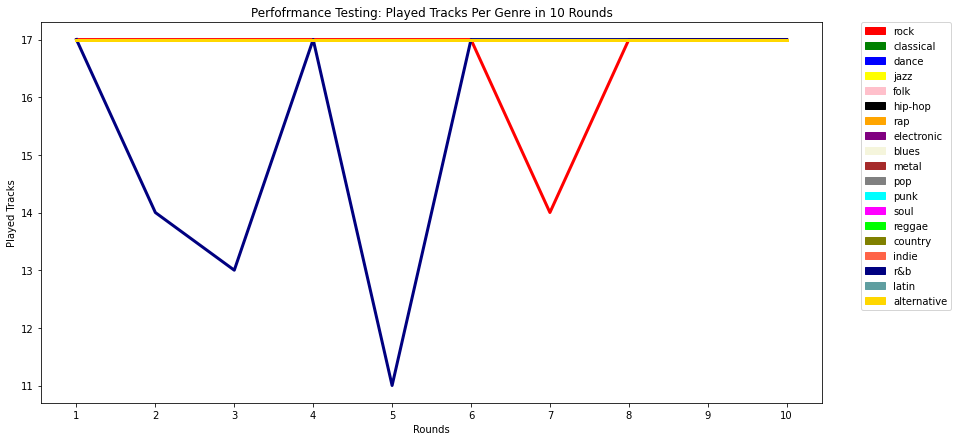

In [36]:
colors = np.array(["NOCOLOR", "red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown", "gray", "cyan", "magenta", "lime", "olive", "tomato", "navy", "cadetblue", "gold"])
gnrs = ['rock', 'classical', 'dance', 'jazz', 'folk', 'hip-hop', 'rap', 'electronic', 'blues', 'metal', 'pop', 'punk', 'soul', 'reggae', 'country', 'indie', 'r&b', 'latin', 'alternative']

iters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.figure(figsize=(14,7))
plt.xlabel("Rounds")
plt.ylabel("Played Tracks")
plt.title("Perfofrmance Testing: Played Tracks Per Genre in 10 Rounds")
plt.plot(iters, rockdf['plays'], color=colors[1], linewidth=3)
plt.plot(iters, classicaldf['plays'], color=colors[2], linewidth=3)
plt.plot(iters, dancedf['plays'], color=colors[3], linewidth=3)
plt.plot(iters, jazzdf['plays'], color=colors[4], linewidth=3)
plt.plot(iters, folkdf['plays'], color=colors[5], linewidth=3)
plt.plot(iters, hiphopdf['plays'], color=colors[6], linewidth=3)
plt.plot(iters, rapdf['plays'], color=colors[7], linewidth=3)
plt.plot(iters, electrodf['plays'], color=colors[8], linewidth=3)
plt.plot(iters, bluesdf['plays'], color=colors[9], linewidth=3)
plt.plot(iters, metaldf['plays'], color=colors[10], linewidth=3)
plt.plot(iters, popdf['plays'], color=colors[11], linewidth=3)
plt.plot(iters, punkdf['plays'], color=colors[12], linewidth=3)
plt.plot(iters, souldf['plays'], color=colors[13], linewidth=3)
plt.plot(iters, reggaedf['plays'], color=colors[14], linewidth=3)
plt.plot(iters, countrydf['plays'], color=colors[15], linewidth=3)
plt.plot(iters, indiedf['plays'], color=colors[16], linewidth=3)
plt.plot(iters, rbdf['plays'], color=colors[17], linewidth=3)
plt.plot(iters, latindf['plays'], color=colors[18], linewidth=3)
plt.plot(iters, altdf['plays'], color=colors[19], linewidth=3)
patch1 = mpatches.Patch(color=colors[1], label=gnrs[0])
patch2 = mpatches.Patch(color=colors[2], label=gnrs[1])
patch3 = mpatches.Patch(color=colors[3], label=gnrs[2])
patch4 = mpatches.Patch(color=colors[4], label=gnrs[3])
patch5 = mpatches.Patch(color=colors[5], label=gnrs[4])
patch6 = mpatches.Patch(color=colors[6], label=gnrs[5])
patch7 = mpatches.Patch(color=colors[7], label=gnrs[6])
patch8 = mpatches.Patch(color=colors[8], label=gnrs[7])
patch9 = mpatches.Patch(color=colors[9], label=gnrs[8])
patch10 = mpatches.Patch(color=colors[10], label=gnrs[9])
patch11 = mpatches.Patch(color=colors[11], label=gnrs[10])
patch12 = mpatches.Patch(color=colors[12], label=gnrs[11])
patch13 = mpatches.Patch(color=colors[13], label=gnrs[12])
patch14 = mpatches.Patch(color=colors[14], label=gnrs[13])
patch15 = mpatches.Patch(color=colors[15], label=gnrs[14])
patch16 = mpatches.Patch(color=colors[16], label=gnrs[15])
patch17 = mpatches.Patch(color=colors[17], label=gnrs[16])
patch18 = mpatches.Patch(color=colors[18], label=gnrs[17])
patch19 = mpatches.Patch(color=colors[19], label=gnrs[18])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, patch16, patch17, patch18, patch19])
#plt.yticks((2, 5, 7, 9, 15, 16, 17, 18))

##### Skips Plot

([<matplotlib.axis.YTick at 0x7f9aa8262640>,
 <a list of 11 Text major ticklabel objects>)

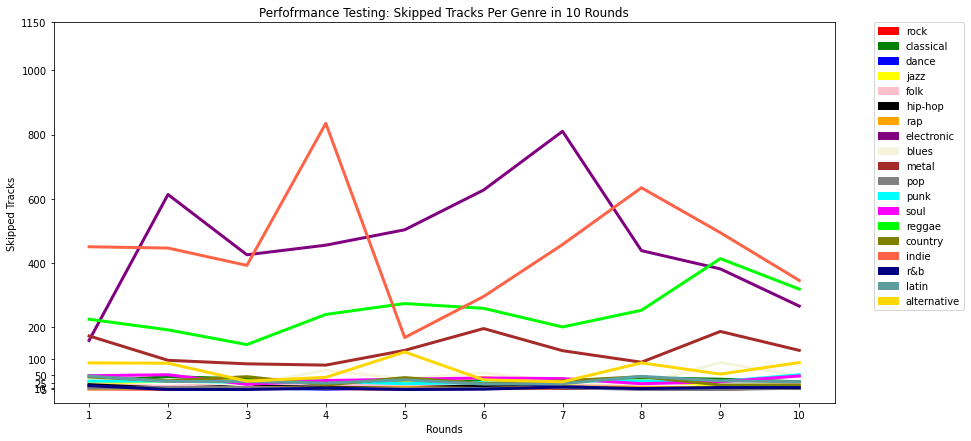

In [37]:
colors = np.array(["NOCOLOR", "red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown", "gray", "cyan", "magenta", "lime", "olive", "tomato", "navy", "cadetblue", "gold"])
gnrs = ['rock', 'classical', 'dance', 'jazz', 'folk', 'hip-hop', 'rap', 'electronic', 'blues', 'metal', 'pop', 'punk', 'soul', 'reggae', 'country', 'indie', 'r&b', 'latin', 'alternative']

iters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.figure(figsize=(14,7))
plt.xlabel("Rounds")
plt.ylabel("Skipped Tracks")
plt.title("Perfofrmance Testing: Skipped Tracks Per Genre in 10 Rounds")
plt.plot(iters, rockdf['skips'], color=colors[1], linewidth=3)
plt.plot(iters, classicaldf['skips'], color=colors[2], linewidth=3)
plt.plot(iters, dancedf['skips'], color=colors[3], linewidth=3)
plt.plot(iters, jazzdf['skips'], color=colors[4], linewidth=3)
plt.plot(iters, folkdf['skips'], color=colors[5], linewidth=3)
plt.plot(iters, hiphopdf['skips'], color=colors[6], linewidth=3)
plt.plot(iters, rapdf['skips'], color=colors[7], linewidth=3)
plt.plot(iters, electrodf['skips'], color=colors[8], linewidth=3)
plt.plot(iters, bluesdf['skips'], color=colors[9], linewidth=3)
plt.plot(iters, metaldf['skips'], color=colors[10], linewidth=3)
plt.plot(iters, popdf['skips'], color=colors[11], linewidth=3)
plt.plot(iters, punkdf['skips'], color=colors[12], linewidth=3)
plt.plot(iters, souldf['skips'], color=colors[13], linewidth=3)
plt.plot(iters, reggaedf['skips'], color=colors[14], linewidth=3)
plt.plot(iters, countrydf['skips'], color=colors[15], linewidth=3)
plt.plot(iters, indiedf['skips'], color=colors[16], linewidth=3)
plt.plot(iters, rbdf['skips'], color=colors[17], linewidth=3)
plt.plot(iters, latindf['skips'], color=colors[18], linewidth=3)
plt.plot(iters, altdf['skips'], color=colors[19], linewidth=3)
patch1 = mpatches.Patch(color=colors[1], label=gnrs[0])
patch2 = mpatches.Patch(color=colors[2], label=gnrs[1])
patch3 = mpatches.Patch(color=colors[3], label=gnrs[2])
patch4 = mpatches.Patch(color=colors[4], label=gnrs[3])
patch5 = mpatches.Patch(color=colors[5], label=gnrs[4])
patch6 = mpatches.Patch(color=colors[6], label=gnrs[5])
patch7 = mpatches.Patch(color=colors[7], label=gnrs[6])
patch8 = mpatches.Patch(color=colors[8], label=gnrs[7])
patch9 = mpatches.Patch(color=colors[9], label=gnrs[8])
patch10 = mpatches.Patch(color=colors[10], label=gnrs[9])
patch11 = mpatches.Patch(color=colors[11], label=gnrs[10])
patch12 = mpatches.Patch(color=colors[12], label=gnrs[11])
patch13 = mpatches.Patch(color=colors[13], label=gnrs[12])
patch14 = mpatches.Patch(color=colors[14], label=gnrs[13])
patch15 = mpatches.Patch(color=colors[15], label=gnrs[14])
patch16 = mpatches.Patch(color=colors[16], label=gnrs[15])
patch17 = mpatches.Patch(color=colors[17], label=gnrs[16])
patch18 = mpatches.Patch(color=colors[18], label=gnrs[17])
patch19 = mpatches.Patch(color=colors[19], label=gnrs[18])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, patch16, patch17, patch18, patch19])
plt.yticks((5, 10, 25, 50, 100, 200, 400, 600, 800, 1000, 1150))


##### P/S Ratio Plot

([<matplotlib.axis.YTick at 0x7f9aa81c7340>,
 <a list of 11 Text major ticklabel objects>)

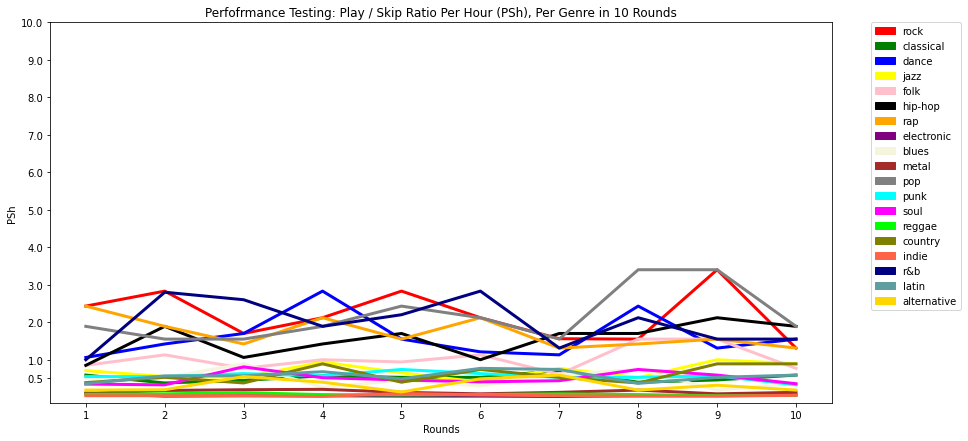

In [38]:
colors = np.array(["NOCOLOR", "red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown", "gray", "cyan", "magenta", "lime", "olive", "tomato", "navy", "cadetblue", "gold"])
gnrs = ['rock', 'classical', 'dance', 'jazz', 'folk', 'hip-hop', 'rap', 'electronic', 'blues', 'metal', 'pop', 'punk', 'soul', 'reggae', 'country', 'indie', 'r&b', 'latin', 'alternative']

iters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.figure(figsize=(14,7))
plt.xlabel("Rounds")
plt.ylabel("PSh")
plt.title("Perfofrmance Testing: Play / Skip Ratio Per Hour (PSh), Per Genre in 10 Rounds")
plt.plot(iters, rockdf['p/s_ratio'], color=colors[1], linewidth=3)
plt.plot(iters, classicaldf['p/s_ratio'], color=colors[2], linewidth=3)
plt.plot(iters, dancedf['p/s_ratio'], color=colors[3], linewidth=3)
plt.plot(iters, jazzdf['p/s_ratio'], color=colors[4], linewidth=3)
plt.plot(iters, folkdf['p/s_ratio'], color=colors[5], linewidth=3)
plt.plot(iters, hiphopdf['p/s_ratio'], color=colors[6], linewidth=3)
plt.plot(iters, rapdf['p/s_ratio'], color=colors[7], linewidth=3)
plt.plot(iters, electrodf['p/s_ratio'], color=colors[8], linewidth=3)
plt.plot(iters, bluesdf['p/s_ratio'], color=colors[9], linewidth=3)
plt.plot(iters, metaldf['p/s_ratio'], color=colors[10], linewidth=3)
plt.plot(iters, popdf['p/s_ratio'], color=colors[11], linewidth=3)
plt.plot(iters, punkdf['p/s_ratio'], color=colors[12], linewidth=3)
plt.plot(iters, souldf['p/s_ratio'], color=colors[13], linewidth=3)
plt.plot(iters, reggaedf['p/s_ratio'], color=colors[14], linewidth=3)
plt.plot(iters, countrydf['p/s_ratio'], color=colors[15], linewidth=3)
plt.plot(iters, indiedf['p/s_ratio'], color=colors[16], linewidth=3)
plt.plot(iters, rbdf['p/s_ratio'], color=colors[17], linewidth=3)
plt.plot(iters, latindf['p/s_ratio'], color=colors[18], linewidth=3)
plt.plot(iters, altdf['p/s_ratio'], color=colors[19], linewidth=3)
patch1 = mpatches.Patch(color=colors[1], label=gnrs[0])
patch2 = mpatches.Patch(color=colors[2], label=gnrs[1])
patch3 = mpatches.Patch(color=colors[3], label=gnrs[2])
patch4 = mpatches.Patch(color=colors[4], label=gnrs[3])
patch5 = mpatches.Patch(color=colors[5], label=gnrs[4])
patch6 = mpatches.Patch(color=colors[6], label=gnrs[5])
patch7 = mpatches.Patch(color=colors[7], label=gnrs[6])
patch8 = mpatches.Patch(color=colors[8], label=gnrs[7])
patch9 = mpatches.Patch(color=colors[9], label=gnrs[8])
patch10 = mpatches.Patch(color=colors[10], label=gnrs[9])
patch11 = mpatches.Patch(color=colors[11], label=gnrs[10])
patch12 = mpatches.Patch(color=colors[12], label=gnrs[11])
patch13 = mpatches.Patch(color=colors[13], label=gnrs[12])
patch14 = mpatches.Patch(color=colors[14], label=gnrs[13])
patch15 = mpatches.Patch(color=colors[15], label=gnrs[14])
patch16 = mpatches.Patch(color=colors[16], label=gnrs[15])
patch17 = mpatches.Patch(color=colors[17], label=gnrs[16])
patch18 = mpatches.Patch(color=colors[18], label=gnrs[17])
patch19 = mpatches.Patch(color=colors[19], label=gnrs[18])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, patch16, patch17, patch18, patch19])
plt.yticks((0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

##### Five Consecutive Plays Plot

([<matplotlib.axis.YTick at 0x7f9aa810d1c0>,
 <a list of 3 Text major ticklabel objects>)

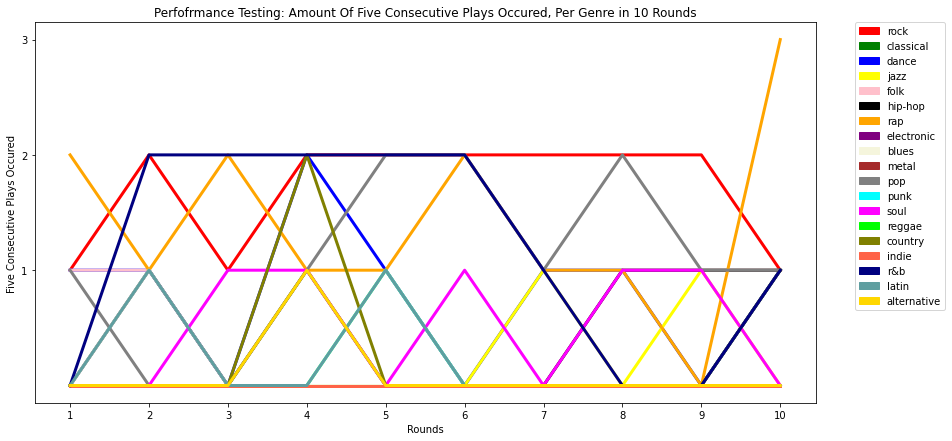

In [39]:
colors = np.array(["NOCOLOR", "red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown", "gray", "cyan", "magenta", "lime", "olive", "tomato", "navy", "cadetblue", "gold"])
clrs = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "beige", "brown", "gray", "cyan", "magenta", "lime", "olive", "tomato", "navy", "cadetblue", "gold"]

gnrs = ['rock', 'classical', 'dance', 'jazz', 'folk', 'hip-hop', 'rap', 'electronic', 'blues', 'metal', 'pop', 'punk', 'soul', 'reggae', 'country', 'indie', 'r&b', 'latin', 'alternative']

iters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.figure(figsize=(14,7))
plt.xlabel("Rounds")
plt.ylabel("Five Consecutive Plays Occured")
plt.title("Perfofrmance Testing: Amount Of Five Consecutive Plays Occured, Per Genre in 10 Rounds")
p1= plt.plot(iters, rockdf['five_cons_plays'], color=colors[1], linewidth=3, label=gnrs[0])
p2= plt.plot(iters, classicaldf['five_cons_plays'], color=colors[2], linewidth=3, label=gnrs[1])
plt.plot(iters, dancedf['five_cons_plays'], color=colors[3], linewidth=3)
plt.plot(iters, jazzdf['five_cons_plays'], color=colors[4], linewidth=3)
plt.plot(iters, folkdf['five_cons_plays'], color=colors[5], linewidth=3)
plt.plot(iters, hiphopdf['five_cons_plays'], color=colors[6], linewidth=3)
plt.plot(iters, rapdf['five_cons_plays'], color=colors[7], linewidth=3)
plt.plot(iters, electrodf['five_cons_plays'], color=colors[8], linewidth=3)
plt.plot(iters, bluesdf['five_cons_plays'], color=colors[9], linewidth=3)
plt.plot(iters, metaldf['five_cons_plays'], color=colors[10], linewidth=3)
plt.plot(iters, popdf['five_cons_plays'], color=colors[11], linewidth=3)
plt.plot(iters, punkdf['five_cons_plays'], color=colors[12], linewidth=3)
plt.plot(iters, souldf['five_cons_plays'], color=colors[13], linewidth=3)
plt.plot(iters, reggaedf['five_cons_plays'], color=colors[14], linewidth=3)
plt.plot(iters, countrydf['five_cons_plays'], color=colors[15], linewidth=3)
plt.plot(iters, indiedf['five_cons_plays'], color=colors[16], linewidth=3)
plt.plot(iters, rbdf['five_cons_plays'], color=colors[17], linewidth=3)
plt.plot(iters, latindf['five_cons_plays'], color=colors[18], linewidth=3)
plt.plot(iters, altdf['five_cons_plays'], color=colors[19], linewidth=3)
patch1 = mpatches.Patch(color=colors[1], label=gnrs[0])
patch2 = mpatches.Patch(color=colors[2], label=gnrs[1])
patch3 = mpatches.Patch(color=colors[3], label=gnrs[2])
patch4 = mpatches.Patch(color=colors[4], label=gnrs[3])
patch5 = mpatches.Patch(color=colors[5], label=gnrs[4])
patch6 = mpatches.Patch(color=colors[6], label=gnrs[5])
patch7 = mpatches.Patch(color=colors[7], label=gnrs[6])
patch8 = mpatches.Patch(color=colors[8], label=gnrs[7])
patch9 = mpatches.Patch(color=colors[9], label=gnrs[8])
patch10 = mpatches.Patch(color=colors[10], label=gnrs[9])
patch11 = mpatches.Patch(color=colors[11], label=gnrs[10])
patch12 = mpatches.Patch(color=colors[12], label=gnrs[11])
patch13 = mpatches.Patch(color=colors[13], label=gnrs[12])
patch14 = mpatches.Patch(color=colors[14], label=gnrs[13])
patch15 = mpatches.Patch(color=colors[15], label=gnrs[14])
patch16 = mpatches.Patch(color=colors[16], label=gnrs[15])
patch17 = mpatches.Patch(color=colors[17], label=gnrs[16])
patch18 = mpatches.Patch(color=colors[18], label=gnrs[17])
patch19 = mpatches.Patch(color=colors[19], label=gnrs[18])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, patch16, patch17, patch18, patch19])
plt.yticks((1, 2, 3))